In [1]:
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def train_val_generators(training_dir, validation_dir):
  train_datagen = ImageDataGenerator(
      rescale=1/255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  train_generator = train_datagen.flow_from_directory(
      directory=train_dir,
      batch_size=20,
      class_mode='categorical',
      target_size=(150, 150)
  )

  val_datagen = ImageDataGenerator(rescale=1/255)

  val_generator = val_datagen.flow_from_directory(
      directory=val_dir,
      batch_size=2,
      class_mode='categorical',
      target_size=(150, 150)
  )

  return train_generator, val_generator

In [3]:
train_dir = 'dataset/train/'
val_dir = 'dataset/validation/'
train_generator, validation_generator = train_val_generators(train_dir, val_dir)

Found 2271 images belonging to 22 classes.
Found 102 images belonging to 22 classes.


In [3]:
chosen_image = random.choice(os.listdir('dataset/train/telur mata sapi'))
img_path = 'dataset/train/telur mata sapi/' + chosen_image
assert os.path.isfile(img_path)

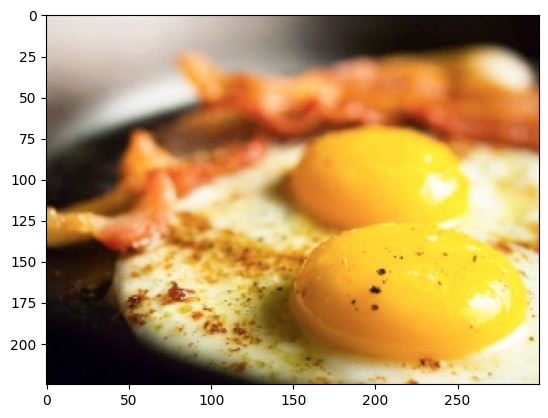

In [6]:
image = np.expand_dims(plt.imread(img_path),0)
plt.imshow(image[0])

In [20]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [93]:
gen = ImageDataGenerator(
      #rescale=1/255,
      rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.2,
      #zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

aug_iter = gen.flow(image)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

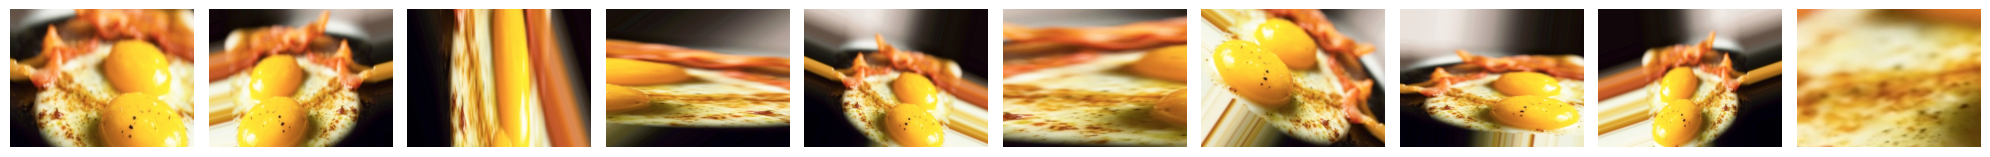

In [94]:
plotImages(aug_images)

In [4]:
train_generator.class_indices

{'anggur': 0,
 'apel': 1,
 'ayam': 2,
 'brokoli': 3,
 'cap cay': 4,
 'ikan': 5,
 'jamur crispy': 6,
 'kentang': 7,
 'mie': 8,
 'nasi': 9,
 'nasi goreng': 10,
 'pempek kapal selam': 11,
 'pisang goreng': 12,
 'rawon': 13,
 'rendang': 14,
 'roti': 15,
 'sate ayam': 16,
 'sate usus': 17,
 'sosis': 18,
 'soto ayam': 19,
 'telur mata sapi': 20,
 'wortel': 21}

In [5]:
validation_generator.class_indices

{'anggur': 0,
 'apel': 1,
 'ayam': 2,
 'brokoli': 3,
 'cap cay': 4,
 'ikan': 5,
 'jamur crispy': 6,
 'kentang': 7,
 'mie': 8,
 'nasi': 9,
 'nasi goreng': 10,
 'pempek kapal selam': 11,
 'pisang goreng': 12,
 'rawon': 13,
 'rendang': 14,
 'roti': 15,
 'sate ayam': 16,
 'sate usus': 17,
 'sosis': 18,
 'soto ayam': 19,
 'telur mata sapi': 20,
 'wortel': 21}

In [6]:
class_names = []
for category in train_generator.class_indices:
  class_names.append(category)
print(class_names)

['anggur', 'apel', 'ayam', 'brokoli', 'cap cay', 'ikan', 'jamur crispy', 'kentang', 'mie', 'nasi', 'nasi goreng', 'pempek kapal selam', 'pisang goreng', 'rawon', 'rendang', 'roti', 'sate ayam', 'sate usus', 'sosis', 'soto ayam', 'telur mata sapi', 'wortel']


In [7]:
# Download the pre-trained weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# Import model
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Set the weights file
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model = InceptionV3(input_shape=(150,150,3),
                               include_top = False,
                               weights = None)

# Load the pre-trained weights
pretrained_model.load_weights(local_weights_file)

# Freeze the weights of the layers
for layer in pretrained_model.layers:
  layer.trainable = False

In [5]:
# Choose 'mixed_7' as the last layer of base model
last_layer = pretrained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [6]:
# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(22, activation='softmax')(x)

# Append the dense network to the base model
model = tf.keras.Model(pretrained_model.input, outputs)
#model.summary()


'''
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(22, activation='softmax')(x)

# Append the dense network to the base model
model = tf.keras.Model(pretrained_model.input, outputs)
model.summary()

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)

# Add a final softmax layer for classification
x = tf.keras.layers.Dense(22, activation='softmax')(x)           

# Append the dense network to the base model
model = tf.keras.Model(pretrained_model.input, outputs)
model.summary()


# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.2)(x)

# Add a final softmax layer for classification
x = tf.keras.layers.Dense(9, activation='softmax')(x)

# Append the dense network to the base model
model = tf.keras.Model(pretrained_model.input, x)
model.summary()
'''

"\n# Add a fully connected layer with 1,024 hidden units and ReLU activation\nx = tf.keras.layers.Dense(128, activation='relu')(x)\n\noutputs = tf.keras.layers.Dense(22, activation='softmax')(x)\n\n# Append the dense network to the base model\nmodel = tf.keras.Model(pretrained_model.input, outputs)\nmodel.summary()\n\n# Flatten the output layer to 1 dimension\nx = tf.keras.layers.Flatten()(last_output)\n\n# Add a fully connected layer with 1,024 hidden units and ReLU activation\nx = tf.keras.layers.Dense(1024, activation='relu')(x)\n\n# Add a dropout rate of 0.2\nx = tf.keras.layers.Dropout(0.2)(x)\n\n# Add a final softmax layer for classification\nx = tf.keras.layers.Dense(22, activation='softmax')(x)           \n\n# Append the dense network to the base model\nmodel = tf.keras.Model(pretrained_model.input, outputs)\nmodel.summary()\n\n\n# Add a dropout rate of 0.2\nx = tf.keras.layers.Dropout(0.2)(x)\n\n# Add a final softmax layer for classification\nx = tf.keras.layers.Dense(9, activ

In [11]:
'''
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(101, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())
'''

"\ninputs = pretrained_model.input\n\nx = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)\nx = tf.keras.layers.Dense(128, activation='relu')(x)\n\noutputs = tf.keras.layers.Dense(101, activation='softmax')(x)\n\nmodel = tf.keras.Model(inputs, outputs)\n\n\nprint(model.summary())\n"

In [7]:
from tensorflow.keras.optimizers import RMSprop, Adam

optimizer1 = RMSprop(learning_rate=1e-5)
optimizer2 = RMSprop(learning_rate=1e-4)
optimizer3 = Adam(learning_rate=1e-5)


In [8]:
model.compile(
    optimizer=optimizer2,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    verbose = 1,
)

Epoch 1/50
114/114 [==============================] - 62s 507ms/step - loss: 2.0287 - accuracy: 0.4232 - val_loss: 1.0324 - val_accuracy: 0.6863
Epoch 2/50
114/114 [==============================] - 53s 465ms/step - loss: 1.1457 - accuracy: 0.6601 - val_loss: 0.6373 - val_accuracy: 0.8137
Epoch 3/50
114/114 [==============================] - 65s 566ms/step - loss: 0.9252 - accuracy: 0.7186 - val_loss: 0.5342 - val_accuracy: 0.8039
Epoch 4/50
114/114 [==============================] - 67s 592ms/step - loss: 0.7778 - accuracy: 0.7640 - val_loss: 0.6258 - val_accuracy: 0.7549
Epoch 5/50
114/114 [==============================] - 67s 591ms/step - loss: 0.6961 - accuracy: 0.7847 - val_loss: 0.4299 - val_accuracy: 0.8529
Epoch 6/50
114/114 [==============================] - 65s 569ms/step - loss: 0.6411 - accuracy: 0.7957 - val_loss: 0.4521 - val_accuracy: 0.8627
Epoch 7/50
114/114 [==============================] - 69s 602ms/step - loss: 0.5992 - accuracy: 0.8067 - val_loss: 0.3927 - val_ac

In [8]:
model.compile(
    optimizer=optimizer1,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    verbose = 1,
)

Epoch 1/50
114/114 [==============================] - 67s 564ms/step - loss: 2.9260 - accuracy: 0.1233 - val_loss: 2.7840 - val_accuracy: 0.2353
Epoch 2/50
114/114 [==============================] - 65s 566ms/step - loss: 2.5526 - accuracy: 0.3043 - val_loss: 2.3419 - val_accuracy: 0.3431
Epoch 3/50
114/114 [==============================] - 65s 569ms/step - loss: 2.2203 - accuracy: 0.4139 - val_loss: 1.9351 - val_accuracy: 0.4902
Epoch 4/50
114/114 [==============================] - 65s 568ms/step - loss: 1.9225 - accuracy: 0.5130 - val_loss: 1.6190 - val_accuracy: 0.6275
Epoch 5/50
114/114 [==============================] - 63s 550ms/step - loss: 1.6901 - accuracy: 0.5830 - val_loss: 1.3644 - val_accuracy: 0.6961
Epoch 6/50
114/114 [==============================] - 60s 523ms/step - loss: 1.5259 - accuracy: 0.6279 - val_loss: 1.1671 - val_accuracy: 0.7647
Epoch 7/50
114/114 [==============================] - 60s 524ms/step - loss: 1.3742 - accuracy: 0.6587 - val_loss: 1.0370 - val_ac

In [130]:
model.compile(
    optimizer=optimizer3,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    verbose = 1,
)

Epoch 1/50
114/114 [==============================] - 78s 649ms/step - loss: 0.3645 - accuracy: 0.8785 - val_loss: 0.2833 - val_accuracy: 0.9020
Epoch 2/50
114/114 [==============================] - 75s 653ms/step - loss: 0.3132 - accuracy: 0.8943 - val_loss: 0.2833 - val_accuracy: 0.9020
Epoch 3/50
114/114 [==============================] - 72s 631ms/step - loss: 0.3499 - accuracy: 0.8886 - val_loss: 0.2810 - val_accuracy: 0.9020
Epoch 4/50
114/114 [==============================] - 72s 629ms/step - loss: 0.3369 - accuracy: 0.8833 - val_loss: 0.2781 - val_accuracy: 0.8922
Epoch 5/50
114/114 [==============================] - 72s 632ms/step - loss: 0.3485 - accuracy: 0.8899 - val_loss: 0.2743 - val_accuracy: 0.8922
Epoch 6/50
114/114 [==============================] - 73s 644ms/step - loss: 0.3290 - accuracy: 0.8939 - val_loss: 0.2801 - val_accuracy: 0.8922
Epoch 7/50
114/114 [==============================] - 66s 576ms/step - loss: 0.3214 - accuracy: 0.8974 - val_loss: 0.2819 - val_ac

In [126]:
model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    epochs = 20,
    validation_data = validation_generator,
    verbose = 1,
)

Epoch 1/20
114/114 [==============================] - 69s 572ms/step - loss: 0.4210 - accuracy: 0.8600 - val_loss: 0.4118 - val_accuracy: 0.8725
Epoch 2/20
114/114 [==============================] - 63s 553ms/step - loss: 0.4023 - accuracy: 0.8661 - val_loss: 0.3817 - val_accuracy: 0.8627
Epoch 3/20
114/114 [==============================] - 64s 565ms/step - loss: 0.4216 - accuracy: 0.8683 - val_loss: 0.3913 - val_accuracy: 0.8529
Epoch 4/20
114/114 [==============================] - 73s 644ms/step - loss: 0.4047 - accuracy: 0.8670 - val_loss: 0.3371 - val_accuracy: 0.8824
Epoch 5/20
114/114 [==============================] - 79s 695ms/step - loss: 0.3709 - accuracy: 0.8811 - val_loss: 0.3021 - val_accuracy: 0.9020
Epoch 6/20
114/114 [==============================] - 75s 657ms/step - loss: 0.4042 - accuracy: 0.8710 - val_loss: 0.3321 - val_accuracy: 0.8725
Epoch 7/20
 37/114 [========>.....................] - ETA: 52s - loss: 0.3604 - accuracy: 0.8906

KeyboardInterrupt: 

In [14]:
history = model.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    verbose = 1,
)

Epoch 1/50
114/114 [==============================] - 76s 662ms/step - loss: 1.6712 - accuracy: 0.4892 - val_loss: 0.8943 - val_accuracy: 0.7353
Epoch 2/50
114/114 [==============================] - 70s 616ms/step - loss: 1.0243 - accuracy: 0.6878 - val_loss: 0.6255 - val_accuracy: 0.7843
Epoch 3/50
114/114 [==============================] - 72s 630ms/step - loss: 0.8606 - accuracy: 0.7248 - val_loss: 0.4114 - val_accuracy: 0.8725
Epoch 4/50
114/114 [==============================] - 64s 560ms/step - loss: 0.7452 - accuracy: 0.7622 - val_loss: 0.5309 - val_accuracy: 0.8137
Epoch 5/50
114/114 [==============================] - 63s 556ms/step - loss: 0.7335 - accuracy: 0.7812 - val_loss: 0.5453 - val_accuracy: 0.8431
Epoch 6/50
114/114 [==============================] - 67s 585ms/step - loss: 0.6136 - accuracy: 0.8005 - val_loss: 0.4115 - val_accuracy: 0.8824
Epoch 7/50
114/114 [==============================] - 66s 575ms/step - loss: 0.5872 - accuracy: 0.8155 - val_loss: 0.5048 - val_ac

# Plotting Accuracy and Loss

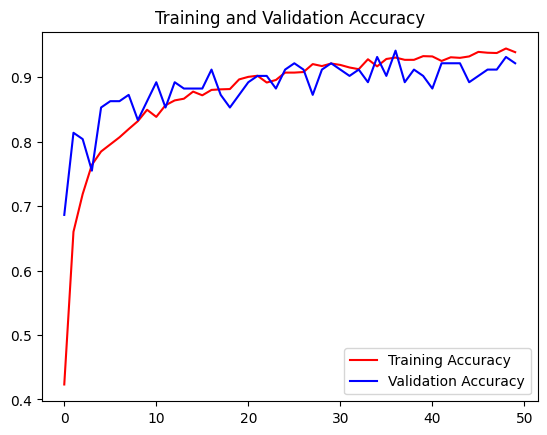

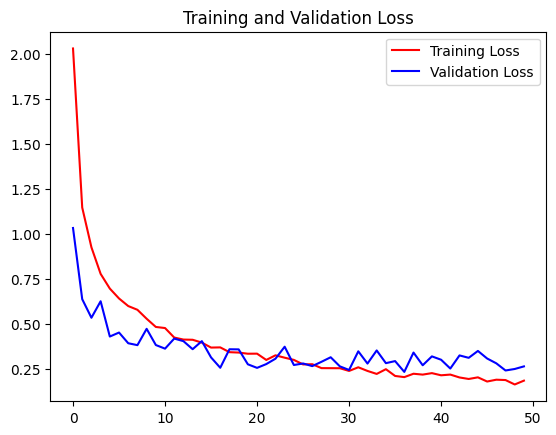

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

# Accuracy
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

# Loss
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

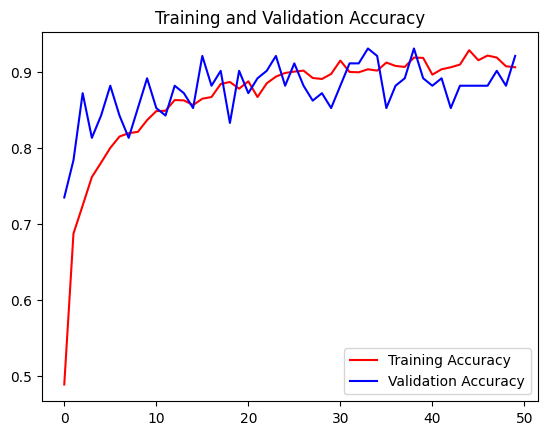

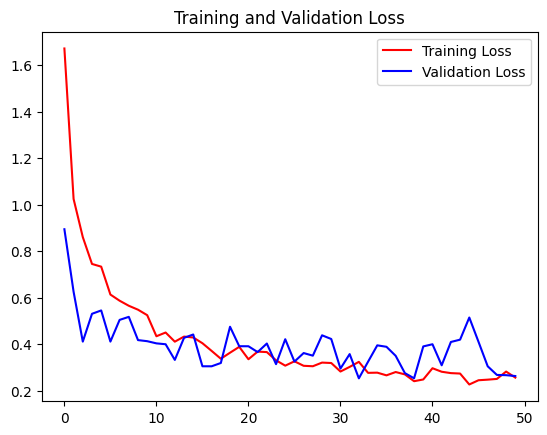

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

# Accuracy
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

# Loss
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

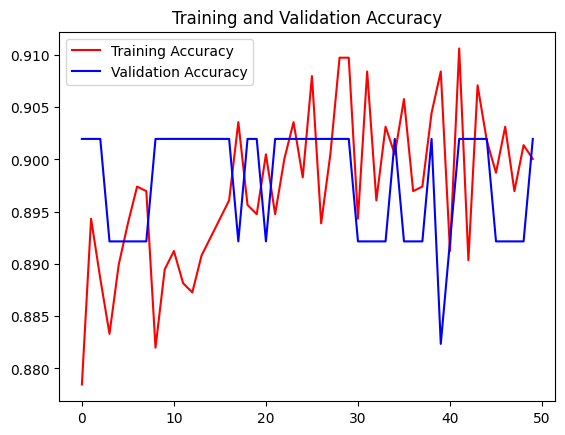

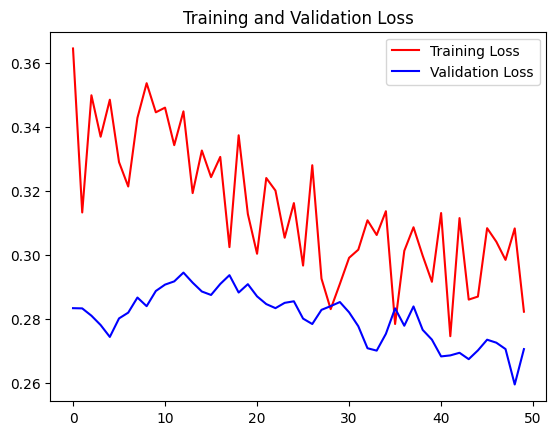

In [132]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))

# Accuracy
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

# Loss
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [10]:
export_dir = 'saved_model/rms1e-4'

tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/rms1e-4\assets


INFO:tensorflow:Assets written to: saved_model/rms1e-4\assets


In [11]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('rmsprop1e-4_model.tflite', 'wb') as f:
  f.write(tflite_model)

In [12]:
# Convert model
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Write TFLite model
tflite_model_file = "rmsprop1e-4_model_compressed.tflite"

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [27]:
## NOTE: If you are using Safari and this cell throws an error,
## please skip this block and run the next one instead.

import numpy as np
from tensorflow.keras.utils import load_img, img_to_array


labels = ['Anggur', 'Apel', 'Ayam Goreng', 'Brokoli', 'Cap Cay', 'Ikan Bakar', 'Jamur Crispy', 'Kentang', 'Mie Goreng', 'Nasi Putih', 'Nasi Goreng', 'Pempek Kapal Selam', 'Pisang Goreng', 'Rawon', 'Rendang', 'Roti', 'Sate Ayam', 'Sate Usus', 'Sosis', 'Soto Ayam', 'Telur Mata Sapi', 'Wortel']

# predicting images
path = 'test_images/WhatsApp Image 2023-06-12 at 10.09.46 PM.jpeg'
img = load_img(path, target_size=(150, 150))
x=img_to_array(img)
x /= 255
x=np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = model.predict(images, batch_size=10)
result = np.argmax(classes)
print(classes[0])
print(f'\nlabels[{result}] = {classes[0,result]}')
print(labels[result])

1/1 [==============================] - 0s 93ms/step
[3.4399263e-09 1.4163840e-10 2.0309013e-10 1.2513381e-10 4.2777945e-08
 9.6709607e-10 7.0217908e-08 6.8197870e-08 7.3686168e-03 4.2782240e-02
 8.8381121e-04 1.3713293e-06 1.0437703e-05 1.5828921e-07 8.5216249e-07
 1.7279624e-09 5.6864218e-11 1.5810349e-09 5.9733307e-10 1.7911314e-06
 9.4895053e-01 7.8950707e-11]

labels[20] = 0.9489505290985107
Telur Mata Sapi
